# Otimização - Modelagem da Superfície Resposta (RSM)

### Imports

In [2]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
#import plotly.express as px
from tqdm import tqdm
pd.set_option('max.columns',500)
%matplotlib inline
from IPython.display import Image

import matplotlib
from IPython.core.display import HTML
from IPython.display import Image
import re
from unidecode import unidecode as und
import pickle
import seaborn as sns

A Modelagem da Superfície Resposta (*Response Surface Modelling* - RSM) é uma área que reúne técnicas que visam estimar a superfície resposta do problema de maneira simplificada.

## 1. Definições

Após a execução do DOE, existirão alguns pontos amostrados em que se conhece os fatores de entrada e a variável resposta. A partir desses pontos, é interessante tentar encontrar uma curva que modele uma função que aproxime a relação entre os fatores e a variável resposta. Essa modelagem é mais precisa quando o processo de DOE foi feito com mais pontos, ou quando o comportamento da variável resposta é razoavelmente regular.

Essas técnicas se dividem em duas classes:
* <u>Interpolação:</u> quando $y_i = f(x_i)$;
* <u>Aproximação:</u> quando $|y_i - f(x_i)| \neq 0$;

Assim, busca-se encontrar uma função $f(x_i)$ que se aproxime do valor da variável resposta $y_i$.

## 2. Técnicas

Como mencionado, as técnicas de RSM são técnicas de aproximação/interpolação, que visam minimizar o erro entre a **função modelo** $\hat{f(x)}$ e a variável resposta $y$.

### 2.1 Mínimos quadrados

Essa técnica de regressão supôe que

$$ 
y = \hat{f(\bm{X}, \bm{\beta})} + \epsilon
$$

em que $\bm{X} = [x_1, ... , x_k ]^T$ é o vetor com as $k$ entradas do experimento, $\bm{\beta} = [\beta_1, ..., \beta_m]$ é o vetor com os $m$ coeficientes da regressão adotada e $\epsilon$ é o resíduo da regressão.

Dessa forma, o objetivo é minimizar o $\epsilon$, ou seja, para um dataset com $N$ amostras, espera-se encontrar parâmetros $\bm{\beta}$ que:

$$
S = \sum_{i=1}^N \epsilon_i^2 = \sum_{i=1}^N (\hat{f}(x_i, \bm{\beta}) - y_i)^2 \\

\therefore \\

\min_{\bm{\beta}} S
$$

Para isso, utiliza-se o gradiente para encontrar a melhor aproximação:

$$
\frac{\partial{S}}{\partial{\bm{\beta}}} \sim 0
$$

Essa é a formulação mais geral da técnica de mínimos quadrados, porque a partir daí surgem diferentes estratégias de modelagem do $\hat{f}$, algumas lineares outras não-lineares, o que também exige diferentes formas de otimização dos parâmetros $\bm{\beta}}$. A tabela abaixo ilustra alguns exemplos comuns de modelagem de $\hat{f}$.

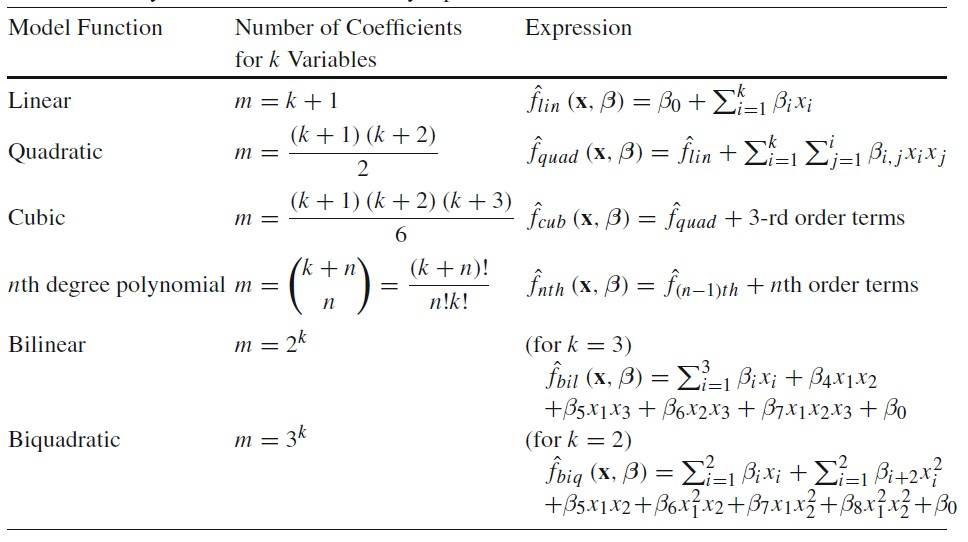

In [13]:
Image('assets/tabela_minimos_quadrados.jpg', width=700)

A mais comum dessas modelagens é a regressão linear, o primeiro caso da tabela acima.

Para avaliar essa técnica, utiliza-se as variáveis conhecidas como parâmetros da regressão, que são definidas como:

* Parâmetro normal da regressão ($R$):
$$
R^2 = 1 - \frac{\sum_{i=1}^N (y_i-\hat{f}(x_i, \bm{\beta}))^2}{\sum_{i=1}^N (y_i-\overline{y})^2}
$$

em que $\overline{y}$ é a média de $y$.

* Parâmetro ajustado da regressão ($R_{adj}$):
$$
R_{adj}^2 = 1 - \frac{\sum_{i=1}^N (y_i-\hat{f}(x_i, \bm{\beta}))^2}{\sum_{i=1}^N (y_i-\overline{y})^2} \cdot \frac{N-1}{N-m}
$$

em que $N$ é o número de amostras usadas na regressão e $m$ o número de parâmetros de modelagem.

* Parâmetro preditivo da regressão ($R_{pred}$):
$$
R_{pred}^2 = 1 - \frac{\sum_{i=1}^N (y_i-\hat{f}(x'_i, \bm{\beta}))^2}{\sum_{i=1}^N (y_i-\overline{y})^2}
$$

em que $x'_i$ é a $i$-ésima amostra que **NÃO** foi usada na regressão, de forma a entender a capacidade de predição da modelagem.


Essa técnica é muito utilizada por sua simplicidade e capacidade de modelagem, mas para problemas em que o comportamento da variável resposta é não linear e não convexo, essas técnicas se tornam pouco precisas e muito suscetíveis a mínimos/máximos locais.

### 2.2 Shepard e K-Nearest

## 3. Aplicação

### 3.1 Redefinição do problema

Para testar as técnicas, usaremos o problema de exemplo do notebook de "Introdução" e a classe que foi criada nele, para especificação do ambiente de otimização. Caso não lembre do problema, recomendamos que releiam a Seção 3 da Introdução.

In [ ]:
class Ambiente():
    '''
    Classe que define o ambiente de simulação do problema em questão, que é o de definir
    como será feita a alocação de produção de carros por fábrica, dado que cada uma delas
    tem custos e tempo de produção próprios.
    '''
    def __init__(self, D, lambda_1=1, lambda_2=1):
        '''
        Inicialização do ambiente

        Parâmetros:
        -----------
            1. D {int}:
                Número de carros que precisam ser produzidos;
            2. lambda_1 e lambda_2 {float}:
                Parâmetros de ajuste das funções subobjetivo.
        '''
        #Definição dos atibutos da classe
        self.D, self.lambda_1, self.lambda_2 = D, lambda_1, lambda_2

        self.n_fabricas = 3
        self.custo_por_carro = np.array([50, 30, 10]) #em milhares de reais
        self.tempo_por_carro = np.array([1, 5, 10]) #em dias
        
        #Cálculo do custo máximo e mínimo e do tempo máximo e mínimo de produção dada a demanda D
        self.max_custo, self.min_tempo = self.compute_costs([0,0,self.D])
        self.min_custo, self.max_tempo = self.compute_costs([self.D,0,0])

    def norm(self, valor, maximo, minimo):
        '''
        Função de normalização máximo e mínimo

        Parâmetros:
        -----------
            1. valor {float}:
                Valor a ser normalizado;
            2. maximo {float}:
                valor máximo da variável;
            3. minimo {float}:
                valor mínimo da variável.

        Saída:
        ------
            1. valor_normalizado {float}:
                Valor normalizado.
        '''
        valor_normalizado = (valor - minimo) / (maximo - minimo)
        return valor_normalizado

    def compute_costs(self, alocacao):
        '''
        Função que calcula o custo de produção e o tempo, dada uma determinada alocação.

        Parâmetros:
        -----------
            1. alocacao {list ou np.array}:
                Alocação definindo quantos carros cada fábrica produzirá.
        
        Saídas:
        -------
            1. custo_pedido {float}:
                Custo de produção, em milhares de reais;
            2. tempo_pedido {float}:
                Tempo de produção, em dias.
        '''
        #Transforma a entrada em um np.array
        alocacao = np.array(alocacao)

        # Dada a alocação, calcula o custo e o tempo de produção
        custo_pedido = np.sum(alocacao*self.custo_por_carro)
        tempo_pedido = np.sum(alocacao*self.tempo_por_carro)

        return custo_pedido, tempo_pedido

    def r(self, f1, f2, omega_1, omega_2):
        '''
        Executa o cálculo de r

        Parâmetros:
        -----------
            1. f1 e f2 {float}:
                Funções subobjetivo.
            2. omega_1, omega_2 {float}:
                Pesos das funções subobjetivos.

        Saída:
        ------

            1. f {float}:
                Valor da função objetivo
        '''
        
        f = omega_1*f1 + omega_2*f2
        return f
        
    def funcao_objetivo(self, alocacao, omega_1, omega_2):
        '''
        Calcula a função objetivo.

        Parâmetros:
        -----------
            1. alocacao {list ou np.array}:
                Alocação definindo quantos carros cada fábrica produzirá.
            2. omega_1, omega_2 {float}:
                pesos dos subobjetivos. A soma dos dois precisa ser igual a 1.

        Saída:
        ------
            1. objetivo {float}:
                Resultado da função objetivo.
        '''
        #Cálculo do custo e o tempo demandado
        custo, tempo = self.compute_costs(alocacao)

        #Cálculo das funções subpbjetivo
        f1, f2 = self.lambda_1*custo, self.lambda_2*tempo

        #Normalização dessas funções usando o custo e tempo máximo e mínimo
        f1_norm, f2_norm = self.norm(f1, self.min_custo, self.max_custo), self.norm(f2, self.min_tempo, self.max_tempo)

        #Cálculo da função objetivo (o negativo é porque o problema é de minimzação)
        objetivo = -self.r(f1_norm, f2_norm, omega_1, omega_2)
        
        if np.sum(alocacao) != self.D: #Penaliza as soluções cuja soma seja maior ou menor que D
            objetivo = -(np.abs(np.sum(alocacao) - self.D))
            
        return objetivo

In [ ]:
env = Ambiente(20)

### 3.5 Conclusão

XXX

## 4. Referências

* [Cavazzuti, Marco. (2013). Optimization methods: from theory to design](https://link.springer.com/book/10.1007/978-3-642-31187-1)